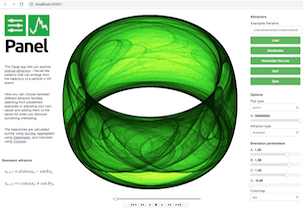

## Panel/Numba/Datashader Strange Attractors app

[Strange attractors](attractors.ipynb) are a type of iterative equation that traces the path of a particle through a 2D space, forming interesting patterns in the trajectories. The patterns differ depending on which sets of equations are used and which parameter values are selected for those equations.

To make the parameter spaces easy to explore, we'll build a web-based application using [Panel](https://panel.holoviz.org) to select between the attractor families, adjust the parameter values for that type of attractor, and see the results rendered using [Datashader](https://datashader.org). Using this app requires `conda install -c pyviz panel datashader` and a live, running Python process, not just a static web page or anaconda.org viewer. 

This dashboard code also functions as an example of how to build a Panel application for working with an arbitrarily large family of Python objects organized into a class hierarchy, without depending on the details of that structure and without that code depending on any GUI libraries. In this approach, each object defines its own parameters in a GUI-independent way, but then Panel can access this information and construct appropriate widgets to provide interactive control of the values. This approach can allow the same codebase be used in a GUI with full interactivity while also supporting non-GUI command-line, batch, or headless usage. New classes added to the .py file, even with entirely different parameters, will automatically be supported by this GUI code.

If you aren't familiar with Panel, you may wish to check out the much simpler [Clifford-only app](clifford_panel.ipynb) first, to understand the basic structure of an app and of how to compute an attractor.


## Attractor definitions

Here, we'll make use of a family of attractors whose code is defined in the separate file [attractors.py](attractors.py), currently including classes for Clifford, De Jong, Svensson, Fractal Dream, Bedhead, Hopalong1, Hopalong2, Gumowski Mira, and Symmetric Icon attractors. That module also provides support for working with a separate YAML-format list of examples of each type of attractor, in [attractors.yml](attractors.yml).

Each attractor family is a subclass of the Attractor class, capturing the attractor equations as runnable Python code, the equations in LaTeX for for displaying, the parameters of the equations, and their expected ranges of values:

In [1]:
import attractors as at

h = at.Hopalong1()
h

Hopalong1(a=9.8, b=4.1, c=3.8, colormap='kgy', equations=['$x_{n+1} = y_n-\\mathrm{sgn}(x_n)\\sqrt{\\left|\\ bx_n-c\\ \\right|}$', '$y_{n+1} = a-x_n$'], name='Hopalong101382', x=0, y=0)

In [2]:
from IPython.core.display import display, HTML, Latex
display(HTML("<style>.container { width:100% !important; }</style>"))

display(*[Latex(e) for e in h.equations])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [3]:
import inspect
print(inspect.getsource(h.fn))

    @staticmethod
    @jit(nopython=True)
    def fn(x, y, a, b, c, *o):
        return y - sqrt(fabs(b * x - c)) * np.sign(x), \
               a - x



We can use the `trajectory` function to run this equation for specified parameter values to calculate `n` (x,y) positions of the simulated particle through space, where each subsequent position is calculated from the previous one:

In [4]:
at.trajectory(h.fn, 0, 0, a=1, b=3, c=5, n=5)

,x,y
0,0.000000,0.000000
1,0.000000,1.000000
2,1.000000,1.000000
3,-0.414214,0.000000
4,2.498528,1.414214


## Attractor parameter values

Many of these attractors have only specific sets of parameters that are visually striking.  Suitable parameters have been collected into a separate [YAML-format text file](https://raw.githubusercontent.com/pyviz-topics/examples/master/attractors/attractors.yml), which we can load here, add new values to, save, etc.:

In [5]:
params = at.ParameterSets(name="Attractors")
params.attractors["Svensson"]

Svensson(a=1.4, b=1.56, c=1.4, colormap='fire', d=-6.56, equations=['$x_{n+1} = d\\ \\sin\\ ax_n - \\sin\\ by_n$', '$y_{n+1} = c\\ \\cos\\ ax_n + \\cos\\ by_n$'], name='Svensson parameters', x=0, y=0)

The `params` object also allows constructing a new Attractor object by name with the given parameters:

In [6]:
params.attractor('Gumowski_Mira', None, 0.1, 0.1, 0.0, 0.5, -0.75)

Gumowski_Mira(a=0.0, b=0.5, colormap=None, equations=['$G(x) = \\mu x + \\frac{2(1-\\mu)x^2}{1+x^2}$', '$x_{n+1} = y_n + ay_n(1-by_n^2) + G(x_n)$', '$y_{n+1} = -x_n + G(x_{n+1})$'], mu=-0.75, name='Gumowski_Mira parameters', x=0.1, y=0.1)

## Attractor plotting using Datashader

To turn the attractors into visible images, we'll define some plotting code using [Datashader](http://datashader.org):

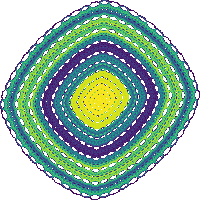

In [7]:
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import inferno, viridis
from colorcet import palette
palette["viridis"]=viridis
palette["inferno"]=inferno

size=700

def datashade(df, plot_type='points', cmap=palette["inferno"], size=size):
    cvs = ds.Canvas(plot_width=size, plot_height=size)
    agg = getattr(cvs,plot_type)(df, 'x', 'y', agg=ds.count())
    return tf.shade(agg, cmap=cmap)

datashade(at.trajectory(at.Hopalong1.fn, 0, 0, a=1, b=3, c=5, n=5000000), cmap=viridis, size=200)

# Panel dashboard

As illustrated above, we can use `datashade` on its own to plot any of these attractors, or `IPython.display.Latex` to render the equations mathematically. But to make it much simpler to explore, let's build an app with widgets using Panel. We'll first make an object that lets us select between attractor families, types of plots, etc.:

In [8]:
import param, panel as pn
from panel.pane import LaTeX
pn.extension('katex')

class Attractors(param.Parameterized):
    attractor_type = param.ObjectSelector(params.attractors["Clifford"], 
                                          params.attractors, precedence=0.9)

    parameters = param.ObjectSelector(params, precedence=-0.5, readonly=True)

    plot_type = param.ObjectSelector("points", precedence=0.8, 
        objects=['points', 'line'], doc="Type of aggregation to use")

    n = param.Integer(2000000, bounds=(1,None), softbounds=(1,50000000),
                      doc="Number of points", precedence=0.85)
    
    @param.depends("parameters.param", watch=True)
    def _update_from_parameters(self):
        a = params.attractor(*self.parameters())
        if a is not self.attractor_type:
            self.set_param(attractor_type=a)
        
    @param.depends("attractor_type.param", "plot_type", "n")
    def view(self):
        return datashade(self.attractor_type(n=self.n), self.plot_type, 
                         palette[self.attractor_type.colormap][::-1])

    @param.depends("attractor_type")
    def equations(self):
        if not self.attractor_type.equations:
            return pn.Column()
        return pn.Column("<b>"+self.attractor_type.__class__.name+" attractor<b>", 
                      *[LaTeX(e) for e in self.attractor_type.equations])

ats = Attractors(name="Options")
params.current = lambda: ats.attractor_type
#ats.view() # Uncomment to see a plot of the current attractor

And we'll create a scrubber widget to make it easy to select between the existing example parameter sets:

In [9]:
from panel.widgets import DiscretePlayer

player = DiscretePlayer(options=params.param.example.objects, interval=2000, align='center')
player.link(params, value='example');

And let's define some explanatory text that will be useful if this app is deployed outside the notebook context where you are reading this:

In [10]:
text = pn.panel("""
<img src="https://panel.pyviz.org/_static/logo_stacked.png" width=180 height=151>

<br><br><i>This [Panel](https://github.com/pyviz/panel) app lets you explore 
[strange attractors](attractors.ipynb) -- 
fractal-like patterns that can emerge from the trajectory of a particle 
in 2D space.<br><br>

Here you can choose between different attractor families, selecting from
predefined examples or adjusting your own values and adding them to the 
saved list when you discover something interesting.<br><br>

The trajectories are calculated quickly using [Numba](http://numba.pydata.org),
aggregated using [Datashader](http://datashader.org), and colorized using
[Colorcet](http://colorcet.pyviz.org).<i>""", width=200)

Ok, now we are ready to put everything together into rows and columns of a dashboard, which we will mark `.servable()` to indicate that the dashboard should be displayed if this notebook is run using `panel serve`:

Row
    [0] HSpacer()
    [1] Column
        [0] Markdown(str, width=200)
        [1] ParamMethod(method, margin=(0, -500, 0, 0))
    [2] Spacer(max_width=20)
    [3] Column
        [0] ParamMethod(method)
        [1] DiscretePlayer(align='center', interval=2000, options=[['Svensson', ...], value=['Svensson', 'fire', ...])
    [4] Spacer(max_width=20)
    [5] Column
        [0] Param(Attractors, expand=True, width=220)
    [6] HSpacer()
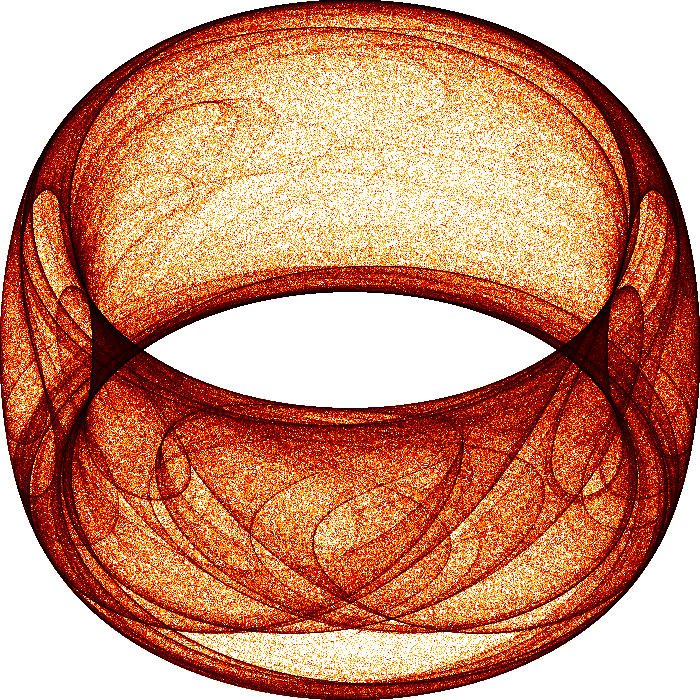

In [11]:
from panel.layout import HSpacer

pn.Row(HSpacer(),
       pn.Column(text, pn.panel(ats.equations,margin=(0,-500,0,0))), pn.Spacer(max_width=20),
       pn.Column(ats.view, player), pn.Spacer(max_width=20),
       pn.Column(pn.Param(ats.param, expand=True, width=220)),
       HSpacer()).servable("Attractors")

You can add `.show()` after `.servable()` if you want to launch a standalone dashboard immediately from within the Jupyter notebook, or just run this notebook through Bokeh Server using `panel serve --show attractors_panel.ipynb`. Either way, you should get a browser tab with a dashboard like in the above cell, which you can explore or share.